# Determine causal drivers of trends in LSP metrics


***

**To Do:**
* Determine best way to extract climate variables corresponding with phenology metrics - in this draft workflow I only extract mean climate over the preceeding two months of a given metric.
* If using PLS, make maps of the coefficients for each variable.
* Consider adding earlier metrics as a co-variable (e.g if modelling POS add SOS.)

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
import sys
import math
import pickle
import warnings
import distinctipy
import xarray as xr
import pandas as pd
import geopandas as gpd
import rioxarray as rxr
from scipy import stats
import seaborn as sb
import numpy as np
import contextily as ctx
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from datetime import datetime
import pymannkendall as mk
from odc.geo.xr import assign_crs
from odc.geo.geom import Geometry
# from matplotlib.colors import ListedColormap
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Patch

from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import LinearRegression

# import shap
# from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score #mean_squared_error
# from sklearn.ensemble import RandomForestRegressor

# sys.path.append('/g/data/os22/chad_tmp/AusEFlux/src/')
# from _utils import start_local_dask

## Analysis Parameters


In [2]:
# product='GIMMS-PKU'
# product='AusENDVI-clim'
product='AusENDVI-clim_MCD43A4'
# product='GIMMS-PKU_2022'
# product='GIMMSv1.1'
# product='GIMMSv1.2'
# product='MCD43A4'
# product='Landsat'
# product='AusENDVI-clim_2000'

base = '/g/data/os22/chad_tmp/Aus_phenology/'

ds_path = '/g/data/os22/chad_tmp/AusENDVI/results/publication/AusENDVI-clim_MCD43A4_gapfilled_1982_2022.nc'

# timeseries_file = '/g/data/os22/chad_tmp/Aus_phenology/data/ecoregions_climate_timeseries.pkl'
# timeseries_file ='/g/data/os22/chad_tmp/Aus_phenology/data/IBRA_regions_climate_timeseries.pkl'
# timeseries_file =f'{base}data/pickle/IBRA_subregions_{product}_climate.pkl'
timeseries_file =f'{base}data/pickle/IBRA_subregions_climate.pkl'

# ecoregions_file = '/g/data/os22/chad_tmp/Aus_phenology/data/vectors/Ecoregions2017_modified.geojson'
# ecoregions_file = '/g/data/os22/chad_tmp/Aus_phenology/data/vectors/IBRAv7_regions_modified.geojson'
ecoregions_file = '/g/data/os22/chad_tmp/Aus_phenology/data/vectors/IBRAv7_subregions_modified.geojson'

phenometrics_file = f'{base}data/pickle/IBRA_subregions_{product}_phenometrics.pkl'

# var='ECO_NAME'
# var='REG_NAME_7'
var='SUB_NAME_7'

## Open climate timeseries and phenometrics

In [3]:
with open(timeseries_file, 'rb') as f:
    climate = pickle.load(f)

with open(phenometrics_file, 'rb') as f:
    phenometrics = pickle.load(f)

#open ecoregions
gdf = gpd.read_file(ecoregions_file)
#remove regions we dropped
gdf = gdf[gdf[var].isin(list(phenometrics.keys()))]

## Maps

In [ ]:
# means = []
# for k in phenometrics.keys():
#     df = phenometrics[k]

#     #include a column counting the number of seasons
#     df['n_seasons'] = len(df)
    
#     mean_df = df.quantile(q=0.5, interpolation='lower') # median
#     mean_df = mean_df.rename({i:'mean_'+i for i in mean_df.index}).to_frame().transpose()
#     mean_df[var] = k

#     mean_gdf = gdf.merge(mean_df, on=var)
#     means.append(mean_gdf)
    
# pheno_means = pd.concat(means).reset_index(drop=True)
# pheno_means[['mean_POS', 'geometry', var]].explore(column='mean_POS', cmap='twilight')

## Calculate climate metrics that relate to phenometrics

Let's start with peak of season (POS) as thats an easy one.

For each ecoregion, find the average date of POS, then we can calculate annual summary statistics around that POS date.  Let's do the two-months preceeding the POS, inclusive. So if the peak is in June, then we can calculate summary statistics from May-June...that'll be a good start

In [ ]:
import sys
sys.path.append('/g/data/os22/chad_tmp/Aus_phenology/src')
from phenology_pixel import regression_attribution

metrics_to_extract = ['vPOS'] #'sos', 'eos', 'los'

for metric in metrics_to_extract:

    if not os.path.exists(f'{base}/data/{metric}/'):
        os.makedirs(f'{base}/data/{metric}/')
    
    pheno_clim={}
    i=0
    for index, row in gdf.iterrows():
        # print(metric+" {:02}/{:02}\r".format(i + 1, len(range(0, len(gdf)))), end="")
        if row[var] == 'East Gippsland Lowlands':
            #open corresponding phenometrics
            pheno = phenometrics[row[var]]
    
            covars = regression_attribution(pheno.to_xarray().expand_dims(latitude=[-33.0],longitude=[135.0]),
                                  climate[row[var]].rename({'CO2':'co2'}),
                                  template=None,
                                  pheno_var='vPOS',
                                  model_type='delta_slope',
                                  modelling_vars=['co2','srad', 'rain','tavg', 'vpd']
                                  ).compute()
            break
        else:
            continue
covars

In [ ]:
bb = xr.full_like(covars, fill_value=np.nan, dtype='float32')
bb.to_netcdf('/g/data/os22/chad_tmp/Aus_phenology/data/templates/template_PCMCI.nc')

In [ ]:
# metrics_to_extract = ['vPOS'] #'sos', 'eos', 'los'

# for metric in metrics_to_extract:

#     if not os.path.exists(f'{base}/data/{metric}/'):
#         os.makedirs(f'{base}/data/{metric}/')
    
#     pheno_clim={}
#     i=0
#     for index, row in gdf.iterrows():
#         print(metric+" {:02}/{:02}\r".format(i + 1, len(range(0, len(gdf)))), end="")
    
#         #open corresponding phenometrics
#         pheno_df = phenometrics[row[var]].rolling(5, min_periods=5).mean().dropna()
#         X=climate[row[var]]
#         # Summarise climate data over length of season for IOS
#         peaks = [pd.Timestamp(datetime.strptime(f'{int(y)} {int(doy)}', '%Y %j')) for y,doy in zip(pheno_df.POS_year, pheno_df.POS)]
        
#         #iterate through each pPOS and summarise climate data.
#         # Use peak-of-year for labelling coordinates
#         clim=[]
#         for p,y in zip(peaks, pheno_df.POS_year):
            
#             #subtract months to find the month-range
#             b = p - pd.DateOffset(months=1)
#             s,e = b.strftime('%Y-%m'), p.strftime('%Y-%m')
            
#             c = X.sel(time=slice(s,e)) #select months before peak

#             r = c['rain']
#             r = r.sum('time')
#             c = c[[x for x in modelling_vars if x != 'rain']]
#             c = c.mean('time')
#             c['rain'] = r
#             c = c.drop_vars('spatial_ref')
#             c = c.assign_coords(year=y)
#             clim.append(c)

#         #join back into a time series xarray
#         c = xr.concat(clim, dim='year')

#         break

#         # 

### vPOS code

In [ ]:
def months_filter(month, start, end):
    return (month >= start) & (month <= end)

metrics_to_extract = ['vPOS'] #'sos', 'eos', 'los'

for metric in metrics_to_extract:

    if not os.path.exists(f'{base}/{metric}/'):
        os.makedirs(f'{base}/{metric}/')
    
    pheno_clim={}
    i=0
    for index, row in gdf.iterrows():
        print(metric+" {:02}/{:02}\r".format(i + 1, len(range(0, len(gdf)))), end="")
    
        #open corresponding phenometrics
        pheno = phenometrics[row[var]]
            
        #find average time for POS - just use a random year
        # doys = [int(i) for i in pheno['pos_times'].values]
        # years = [i for i in pheno.year.values]
        # times = [pd.Timestamp(datetime.strptime(f'{y} {d}', '%Y %j')) for y, d in zip(years,doys)]
        mean_pos = pd.Timestamp(datetime.strptime(f'{2000} {int(pheno.POS.mean())}', '%Y %j'))
    
        #subtract 2 months to find the month-range for summarising climate
        months_before = mean_pos - pd.DateOffset(months=1)
    
        ##NEED TO IMPROVE THIS SO WHEN MONTHS GO FROM 12-2 FOR EXAMPLE IT STILL WORKS
        # m_r = list(range(months_before.month, mean_pos.month+1, 1))
        m_r = months_before.month, mean_pos.month
        # print(m_r)
    
        #now we meed to index the climate data by the range of months
        trimmed_climate = climate[row[var]].sel(time=months_filter(climate[row[var]]['time.month'],
                                                    m_r[0], m_r[-1]))

        # select years in climate only in years when peaks occur 
        # trimmed_climate = trimmed_climate.sel(year=pheno['POS_year'].values)
        
        #calculate annual climate summary stats
        rain=trimmed_climate['rain']
        rain=rain.groupby('time.year').sum()
        trimmed_climate = trimmed_climate[['CO2', 'srad', 'tavg', 'vpd', 'trees']]
        annual_climate = trimmed_climate.groupby('time.year').mean()
        annual_climate = annual_climate.sel(year=pheno['POS_year'].values)
        annual_climate['rain'] = rain.sel(year=pheno['POS_year'].values)
    
        # join our POS metric to the climate data after updating
        # index of our metric with the years
        pheno[f'{metric}'].index = pheno['POS_year'].values
        pheno[f'{metric}'].index.name = 'year'
        annual_climate[f'{metric}'] = pheno[f'{metric}']
        
        # if metric != 'los':
        #     annual_climate[f'{metric}'] = pheno[f'{metric}']
    
        #add to results dict
        pheno_clim[row[var]] = annual_climate
        i+=1
    # #export model input data
    for k,v in pheno_clim.items():
        n=k.replace(" ", "_")
        pheno_clim[k].drop_vars('spatial_ref').to_dataframe().to_csv(f'{base}data/{metric}/{n}_{metric}_model_data.csv')
        

## Develop regressions models to predict change in phenometrics

To do: extract 'trends' from each timeseries through decomposition and then regress the trends

In [6]:
path = '/g/data/os22/chad_tmp/Aus_phenology/data/vPOS/Daintree-Bloomfield_vPOS_model_data.csv'
pheno_var= 'vPOS'

### Exploratory Plot

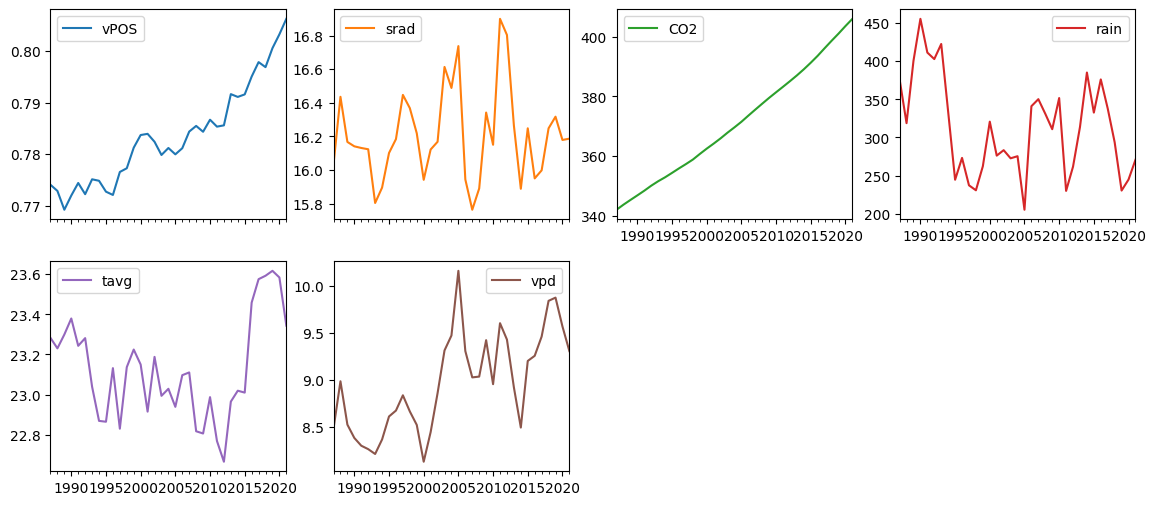

In [7]:
df = pd.read_csv(path, index_col='year')

df.index = [pd.Timestamp(datetime.strptime(f'{int(y)}', '%Y')) for y in df.index]
# df = df.resample('3YE').mean()
df = df.rolling(5, min_periods=5).mean()

df = df.dropna()
df = df[['vPOS', 'srad', 'CO2', 'rain', 'tavg', 'vpd']]
df.plot(subplots=True, layout=(2,4), figsize=(14,6));

## Tst Causal ML methods e.g. econDML

In [ ]:
from econml.dml import LinearDML, CausalForestDML
from sklearn.base import BaseEstimator, clone
import shap
from sklearn.ensemble import RandomForestRegressor

In [ ]:
#first fit a model with all vars
X = df[['CO2','rain', 'tavg', 'vpd', 'srad']]
y = df[pheno_var]

In [ ]:
# Run Double ML, controlling for all the other features
def double_ml(y, causal_feature, control_features):
    """Use doubleML from econML to estimate the slope of the causal effect of a feature."""
    # rf = RandomForestRegressor(n_estimators=100, random_state = 1)
    est = LinearDML(model_y='auto')
    est.fit(y, causal_feature, W=control_features)
    return est

def plot_effect(effect, xs, true_ys, ylim=None):
    """Plot a double ML effect estimate from econML as a line.

    Note that the effect estimate from double ML is an average effect *slope* not a full
    function. So we arbitrarily draw the slope of the line as passing through the origin.
    """
    plt.figure(figsize=(5, 3))

    pred_xs = [xs.min(), xs.max()]
    mid = (xs.min() + xs.max()) / 2
    [effect.pred[0] * (xs.min() - mid), effect.pred[0] * (xs.max() - mid)]

    #plt.plot(xs, true_ys - true_ys[0], label="True causal effect", color="black", linewidth=3)
    point_pred = effect.point_estimate * pred_xs
    pred_stderr = effect.stderr * np.abs(pred_xs)
    plt.plot(
        pred_xs,
        point_pred - point_pred[0],
        label="Double ML slope",
        color=shap.plots.colors.blue_rgb,
        linewidth=3,
    )
    # 99.9% CI
    plt.fill_between(
        pred_xs,
        point_pred - point_pred[0] - 3.291 * pred_stderr,
        point_pred - point_pred[0] + 3.291 * pred_stderr,
        alpha=0.2,
        color=shap.plots.colors.blue_rgb,
    )
    plt.legend()
    plt.xlabel("CO2", fontsize=13)
    plt.ylabel("Zero centered effect")
    if ylim is not None:
        plt.ylim(*ylim)
    plt.gca().xaxis.set_ticks_position("bottom")
    plt.gca().yaxis.set_ticks_position("left")
    plt.gca().spines["right"].set_visible(False)
    plt.gca().spines["top"].set_visible(False)
    plt.show()

def marginal_effects(X, num_samples=100, columns=None, max_points=20, logit=True, seed=0):
    """Helper function to compute the true marginal causal effects."""
    if columns is None:
        columns = X.columns
    ys = [[] for _ in columns]
    xs = [X[c].values for c in columns]
    xs = np.sort(xs, axis=1)
    xs = [xs[i] for i in range(len(xs))]
    return list(zip(xs, ys))

In [ ]:
# estimate the causal effect of CO2 controlling for all the other features
causal_feature = "CO2"
control_features = ['vpd', 'tavg', 'rain', 'srad']
effect = double_ml(y, X[causal_feature], X.loc[:, control_features])

In [ ]:
# plot the estimated slope against the true effect
xs, true_ys = marginal_effects(X, 10000, X[[causal_feature]], logit=False)[0]
plot_effect(effect, xs, true_ys, ylim=(-0.2, 0.2))

## Causal discovery using PCMCI

In [4]:
import tigramite
from tigramite import plotting as tp
from tigramite import data_processing as pp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests.robust_parcorr import RobustParCorr

Assumed links of 0: {(1, 0): 'o?o', (2, 0): 'o?o', (3, 0): 'o?o', (4, 0): 'o?o', (5, 0): 'o?o'}
Assumed links of 1: {}
Assumed links of 2: {(0, 0): 'o?o', (1, 0): 'o?o', (3, 0): 'o?o', (4, 0): 'o?o', (5, 0): 'o?o'}
Assumed links of 3: {(0, 0): 'o?o', (1, 0): 'o?o', (2, 0): 'o?o', (4, 0): 'o?o', (5, 0): 'o?o'}
Assumed links of 4: {(0, 0): 'o?o', (1, 0): 'o?o', (2, 0): 'o?o', (3, 0): 'o?o', (5, 0): 'o?o'}
Assumed links of 5: {(0, 0): 'o?o', (1, 0): 'o?o', (2, 0): 'o?o', (3, 0): 'o?o', (4, 0): 'o?o'}


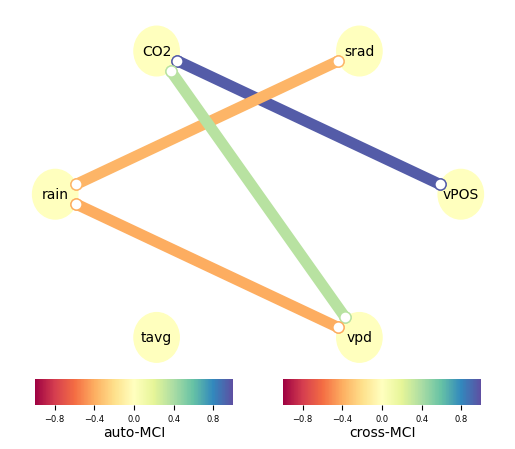

In [16]:
data = df.values
var_names = list(df.columns)
T, N = data.shape
tau_max = 0

# Initialize dataframe object, specify time axis and variable names
dataframe = pp.DataFrame(df.values, 
                         datatime = df.index, 
                         var_names=var_names)


pcmci = PCMCI(
    dataframe=dataframe, 
    cond_ind_test=RobustParCorr(),
    verbosity=0)

# # Make solar have no parents
idx_srad = df.columns.get_loc("srad")
link_assumptions_with_absent_link= {idx_srad: {(i, -tau):'' for i in range(N) for tau in range(0, tau_max+1) if not (i==idx_srad and tau==0)}}
link_assumptions =  PCMCI.build_link_assumptions(link_assumptions_absent_link_means_no_knowledge=link_assumptions_with_absent_link,
                                   n_component_time_series=N,
                                   tau_max=tau_max,
                                   tau_min=0)
for j in link_assumptions:
    print(f"Assumed links of {j}: {link_assumptions[j]}")

pcmci.verbosity = 0
results = pcmci.run_pcmciplus(tau_max=tau_max, pc_alpha=0.05, link_assumptions=link_assumptions)

# ## because vPOS is the first column in the dataframe, if we want to extract the MCI values for vPOS we index for the first array in val_matrix
# mci_vpos = pd.DataFrame(results['val_matrix'][0]).rename({0:'MCI partial correlations'}, axis=1).reset_index(drop=True).set_index(df.columns)
# mci_vpos['p_value'] = pd.DataFrame(results['p_matrix'][0]).rename({0:'p_values'}, axis=1).reset_index(drop=True).set_index(df.columns)

tp.plot_graph(
    val_matrix=results['val_matrix'],
    graph=results['graph'],
    cmap_edges='Spectral',
    cmap_nodes='Spectral',
    var_names=var_names,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',
    );

In [ ]:
base = '/g/data/os22/chad_tmp/Aus_phenology/data/'
metrics_to_extract = ['vPOS'] #'sos', 'eos', 'los'
pheno_var = 'vPOS'
for metric in metrics_to_extract:
    files = [f for f in os.listdir(f'{base}{metric}/') if f.endswith('.csv') ]
    files.sort()
    print(metric)
    
    dffs = []
    for f in files:
        name = f.removesuffix('_'+metric+'_model_data.csv').replace("_", " ")
        # print('', name)
        
        #open data
        df = pd.read_csv(f'{base}{metric}/{f}', index_col='year')
        
        df.index = [pd.Timestamp(datetime.strptime(f'{int(y)}', '%Y')) for y in df.index]
        # df = df.resample('3YE').mean()
        df = df.rolling(5, min_periods=5).mean()
        
        df = df.dropna() 
        
        # Initialize dataframe object, specify time axis and variable names
        T, N = df.values.shape
        dataframe = pp.DataFrame(df.values, 
                                 datatime=df.index, 
                                 var_names=df.columns)
    
        pcmci = PCMCI(
            dataframe=dataframe, 
            cond_ind_test=RobustParCorr(),
            verbosity=0)
        
        # # Make solar have no parents.
        idx_srad = df.columns.get_loc("srad")
        link_assumptions_with_absent_link= {idx_srad: {(i, -tau):'' for i in range(N) for tau in range(0, tau_max+1) if not (i==idx_srad and tau==0)}}
        link_assumptions =  PCMCI.build_link_assumptions(link_assumptions_with_absent_link,
                                           n_component_time_series=N,
                                           tau_max=tau_max,
                                           tau_min=0)
        
        pcmci.verbosity = 0
        results = pcmci.run_pcmciplus(tau_max=0, pc_alpha=0.05,
                            link_assumptions=link_assumptions)

        ## because vPOS is the first column in the dataframe, if we want to extract the MCI values for vPOS we index for the first array in val_matrix
        fi = pd.DataFrame(results['val_matrix'][0]).rename({0:'PCMCI'}, axis=1).reset_index(drop=True).set_index(df.columns)
        fi['p_values'] = pd.DataFrame(results['p_matrix'][0]).rename({0:'p_values'}, axis=1).reset_index(drop=True).set_index(df.columns)
        fi = fi.loc[[fi['PCMCI'].abs().idxmax()]]
        
        fi = fi.reset_index().rename({'index':'feature'},axis=1)
        fi[var] = name
        dffs.append(fi)
    
    top_features = pd.concat(dffs).reset_index(drop=True)
    gdf_with_feature = gdf.merge(top_features, on=var)
    

In [ ]:
fi.index.name ='feature'

In [ ]:
['VPOS'] + ['CO2', 'rain', 'srad', 'tavg', 'vpd']

In [ ]:
fi.drop('vPOS').to_xarray().squeeze().expand_dims(latitude=[-33],longitude=[125])

In [ ]:
colors = distinctipy.get_colors(len(df.columns)-1,rng=4, pastel_factor=0.3, colorblind_type='Deuteranomaly')
cmap = LinearSegmentedColormap.from_list('features', colors, N=len(df.columns)-1)

fig,ax=plt.subplots(1,2, figsize=(10,5), sharey=True, layout='constrained')

gdf_with_feature.plot(edgecolor="black", linewidth=0.05,facecolor='none', ax=ax[0])
a = gdf_with_feature.plot(column='feature', ax=ax[0], legend=True, cmap=cmap)
ctx.add_basemap(a, source=ctx.providers.CartoDB.VoyagerNoLabels, crs='EPSG:4326', attribution='', attribution_size=1)

gdf_with_feature.plot(edgecolor="black", linewidth=0.05,facecolor='none', ax=ax[1])
a=gdf_with_feature.plot(column='PCMCI', ax=ax[1], legend=True, vmin=-0.9, vmax=0.9, cmap='Spectral', legend_kwds={'shrink':0.8})
ctx.add_basemap(a, source=ctx.providers.CartoDB.VoyagerNoLabels, crs='EPSG:4326', attribution='', attribution_size=1)

# ax[0].set_title('vPOS Slope (NDVI/yr, p<=0.0.05) 1982-2022')
# ax[1].set_title('vPOS most important variable');
# ax[2].set_title('Sensitivity (PCMCI)');

## Iterative linear modelling

To determine the impact each variable has on predicting the slope of phenometric

In [ ]:
#first fit a model with all vars
x = df[['CO2','rain', 'tavg', 'vpd', 'srad']]
y = df[pheno_var]

lr = PLSRegression().fit(x, y)
# lr = BayesianRidge().fit(x, y)
# lr = LinearRegression().fit(x, y)
# lr = TheilSenRegressor().fit(x, y)
prediction = lr.predict(x)
r2_all = r2_score(y, prediction)

#calculate slope of predicted variable with all params
# s_actual, i, r, p, se = stats.linregress(df.index, y)
result = mk.original_test(y, alpha=0.1) #
s_actual = result.slope
i_actual = result.intercept

# s, i, r, p, se = stats.linregress(df.index, prediction)
result_pred = mk.original_test(prediction, alpha=0.1) #
s_prediction = result_pred.slope
print(s_actual, s_prediction)
print(lr.coef_)

fig,ax=plt.subplots(1,1, figsize=(7,4))
# ax.plot(y.values, label='Observed', c='tab:blue')
y_vals = result.intercept + result.slope *range(0,len(x.index))
ax.plot(range(0,len(x.index)), y_vals, label=f'Obs., s={s_actual:0.5f} yr\u207B\u00B9')
# ax.plot(prediction, label='All')

# now fit a model without a given variable
# and calculate the slope of the phenometric
r_delta={}
s_delta={}
for v in ['CO2','rain', 'tavg', 'vpd', 'srad']:
    #set variable as constant 
    # constant = x[v].mean()
    constant = x[v][0:1].mean()
    xx = x.drop(v, axis=1)
    xx[v] = constant

    #model and determine slope
    # lr = TheilSenRegressor().fit(xx, y)
    # lr = LinearRegression().fit(xx, y)
    # lr = BayesianRidge().fit(xx, y)
    lrr = PLSRegression().fit(xx, y)
    pred = lrr.predict(xx)
    r2 = r2_score(y, pred)
    # s_p, i, r, p, se = stats.linregress(df.index, pred)
    resulty = mk.original_test(pred, alpha=0.1) #
    s_p = resulty.slope
    
    # plt.plot(y.values, label='Real')
    # Fx_slopes_plot(s_p, resulty.intercept, y.values, ax=ax)
    y_vals = resulty.intercept + resulty.slope *range(0,len(x.index))
    ax.plot(range(0,len(x.index)), y_vals, label=f'{v}, s={s_p:0.5f} yr\u207B\u00B9')
    # ax.plot(pred, label=v)
    #determine the eucliden distance between
    #modelled slope and actual (and r2)
    
    s_delta[v] = math.dist((s_prediction,), (s_p,))
    r_delta[v] = math.dist((r2_all,), (r2,))

ax.plot(y.values, c='black', linestyle='--')
ax.legend()
# ax.plot(y.values, label='Observed', c='tab:blue')
ax.set_xticks(ticks = range(0,40, 4), labels=range(1985,2022, 4))
ax.set_ylabel('vPOS linear trend (NDVI)')
ax.set_title('Daintree-Bloomfield')
ax.grid()

s_delta = pd.Series(s_delta)
r_delta = pd.Series(r_delta)
sensivity = pd.concat([s_delta, r_delta], axis=1).rename({0:'Slope_difference', 1:'r2_difference'}, axis=1)
sensivity

fig.savefig(f'/g/data/os22/chad_tmp/Aus_phenology/results/figs/delta_slope_methods_example.png',
            bbox_inches='tight', dpi=300)

## Model causal drivers

trying a couple of methods

In [ ]:
base = '/g/data/os22/chad_tmp/Aus_phenology/data/'
metrics_to_extract = ['vPOS'] #'sos', 'eos', 'los'
pheno_var = 'vPOS'

In [ ]:
# gdf = gpd.read_file('/g/data/os22/chad_tmp/Aus_phenology/data/Ecoregions2017_aus_processed.geojson')

### Using iterative linear modelling
Delta-slope method

In [ ]:
for metric in metrics_to_extract:
    files = [f for f in os.listdir(f'{base}{metric}/') if f.endswith('.csv') ]
    files.sort()
    print(metric)
    
    dffs = []
    for f in files:
        name = f.removesuffix('_'+metric+'_model_data.csv').replace("_", " ")
        # print('', name)
        
        #open data
        df = pd.read_csv(f'{base}{metric}/{f}', index_col='year')
        # df = df[[metric, 'CO2', 'rain', 'srad', 'tavg', 'vpd']]
        df = df.rolling(5, min_periods=5).mean()
        df = df.dropna()
        
        #first fit a model with all vars
        x = df[['CO2','rain', 'tavg', 'vpd', 'srad']]
        y = df[pheno_var]
        lr = PLSRegression().fit(x, y)
        prediction = lr.predict(x)
        r2_all = r2_score(y, prediction)

        # Find the robust slope of actual
        result_actual = mk.original_test(y, alpha=0.1) #
        p_actual = result_actual.p
        s_actual = result_actual.slope
        
        #calculate slope of predicted variable with all params
        result_prediction = mk.original_test(prediction, alpha=0.1) #
        p_prediction = result_prediction.p
        s_prediction = result_prediction.slope

        # now fit a model without a given variable
        # and calculate the slope of the phenometric
        r_delta={}
        s_delta={}
        for v in ['CO2', 'rain', 'tavg', 'vpd', 'srad']:
            #set variable of interest as a constant value 
            constant = x[v].mean()
            xx = x.drop(v, axis=1)
            xx[v] = constant
        
            #model and determine slope
            lrr = PLSRegression().fit(xx, y)
            pred = lrr.predict(xx)
            r2 = r2_score(y, pred)
            
            result_p = mk.original_test(pred, alpha=0.1)
            s_p = result_p.slope

            #determine the eucliden distance between
            #modelled slope and actual slope (and r2)
            s_delta[v] = math.dist((s_prediction,), (s_p,))
            r_delta[v] = math.dist((r2_all,), (r2,))

        #determine most important feature
        s_delta = pd.Series(s_delta)
        r_delta = pd.Series(r_delta)
        fi = pd.concat([s_delta, r_delta], axis=1).rename({0:'slope_difference', 1:'r2_difference'}, axis=1)
        fi = fi.loc[[fi['slope_difference'].idxmax()]]
        fi = fi.reset_index().rename({'index':'feature'},axis=1)

        #create tidy df
        fi[var] = name
        fi['phenometric'] = pheno_var
        fi['slope_actual'] = s_actual
        fi['slope_modelled'] = s_prediction
        fi['p_values'] = p_actual
        fi['r2'] = r2_all
        dffs.append(fi)
    
    top_features = pd.concat(dffs).reset_index(drop=True)
    gdf_with_feature = gdf.merge(top_features, on=var)
      

### Plot slope method

In [ ]:
colors = distinctipy.get_colors(len(x.columns),rng=4, pastel_factor=0.3, colorblind_type='Deuteranomaly')
cmap = LinearSegmentedColormap.from_list('features', colors, N=len(x.columns))

In [ ]:
fig,ax=plt.subplots(1,3, figsize=(18,5), sharey=True, layout='constrained')

significant = gdf_with_feature[gdf_with_feature['p_values'] <= 0.05]

gdf_with_feature.plot(edgecolor="black", linewidth=0.05,facecolor='none', ax=ax[0])
a=significant.plot(column='slope_actual', ax=ax[0], legend=True, cmap='BrBG', vmax=0.0015,
                   vmin=-0.0015, legend_kwds={'shrink':0.8}) #  edgecolor="black", linewidth=0.1 cmap='BrBG',
ctx.add_basemap(a, source=ctx.providers.CartoDB.VoyagerNoLabels, crs='EPSG:4326', attribution='', attribution_size=1)

gdf_with_feature.plot(edgecolor="black", linewidth=0.05,facecolor='none', ax=ax[1])

a=significant.plot(column='feature', ax=ax[1], legend=True, cmap=cmap) # 
ctx.add_basemap(a, source=ctx.providers.CartoDB.VoyagerNoLabels, crs='EPSG:4326', attribution='', attribution_size=1)

gdf_with_feature.plot(edgecolor="black", linewidth=0.05,facecolor='none', ax=ax[2])
a=significant.plot(column='slope_difference', ax=ax[2], legend=True,  vmin=0, vmax=0.0014, cmap='magma', legend_kwds={'shrink':0.8})
ctx.add_basemap(a, source=ctx.providers.CartoDB.VoyagerNoLabels, crs='EPSG:4326', attribution='', attribution_size=1)

ax[0].set_title('vPOS Slope (NDVI/yr, p<=0.05) 1982-2022')
ax[1].set_title('vPOS most important variable');
ax[2].set_title('Sensitivity ('+u'Δslope'+')');

### Relationship between environmental gradients and CO2 sensitivity

In [ ]:
mi = xr.open_dataarray('/g/data/os22/chad_tmp/Aus_phenology/data/MI_1982_2022.nc')
mi = mi.mean('time')
mi = assign_crs(mi, crs='EPSG:4326')
mi = mi.rename('P:PET')
mi = xr.where(mi>3, np.nan, mi) #remove extreme values

In [ ]:
results={}
for index,row in significant.iterrows():

    #mask the wcf and mi datasets
    geom = Geometry(geom=row.geometry, crs=significant.crs)
    moist = mi.odc.mask(poly=geom)
    moist = moist.mean(['latitude','longitude']).values.item()

    results[row.SUB_NAME_7] = moist

results = pd.Series(results,name='P:PET')
significant = significant.join(results, on='SUB_NAME_7')

In [ ]:
fig,ax=plt.subplots(1,1, figsize=(5,4),  layout='constrained', sharey=True, sharex=True)

obs,pred = significant['P:PET'].values, significant['slope_difference'].values
mask = ~np.isnan(obs) & ~np.isnan(pred)
sl, i, r, p, s = stats.linregress(obs,pred)
r2 = r**2

xy = np.vstack([obs[mask],pred[mask]])
z = gaussian_kde(xy)(xy)

sb.scatterplot(data=significant, x='P:PET',y='slope_difference', alpha=0.5, ax=ax, c=z)
sb.regplot(data=significant, x='P:PET',y='slope_difference',  scatter=False,
           line_kws={'linewidth':1}, color='black', ax=ax, robust=True)
# ax.set_ylim(-0.006, 0.006)
ax.set_title(u'Δslope'+' method')
ax.set_ylabel('CO2 Sensitivity ('+u'Δslope'+')')
# ax.axhline(0, color='grey', linestyle='--')
ax.text(.70, .90, 'r\N{SUPERSCRIPT TWO}={:.2f}'.format(r2),
        transform=ax.transAxes, fontsize=12)
ax.text(.70, .825, 'p={:.3f}'.format(p), transform=ax.transAxes, fontsize=12)

### Partial least squares regression coefficients methods

In [ ]:
for metric in metrics_to_extract:
    files = [f for f in os.listdir(f'{base}{metric}/') if f.endswith('.csv') ]
    files.sort()
    print(metric)
    
    dffs = []
    for f in files:
        name = f.removesuffix('_'+metric+'_model_data.csv').replace("_", " ")
        # print('', name)
        
        #open data
        df = pd.read_csv(f'{base}{metric}/{f}', index_col='year')
        # df = df[[metric, 'CO2', 'rain', 'srad', 'tavg', 'vpd']]
        df = df.rolling(5, min_periods=5).mean()
        df = df.dropna()
        
        #first fit a model with all vars
        x = df[['CO2','rain', 'tavg', 'vpd', 'srad']]
        y = df[pheno_var]
        lr = PLSRegression().fit(x, y)
        prediction = lr.predict(x)
        r2_all = r2_score(y, prediction)

        # Find the robust slope of actual
        result_actual = mk.original_test(y, alpha=0.1) #
        p_actual = result_actual.p
        s_actual = result_actual.slope
        
        #calculate slope of predicted variable with all params
        result_prediction = mk.original_test(prediction, alpha=0.1) #
        p_prediction = result_prediction.p
        s_prediction = result_prediction.slope

        fi = pd.Series(dict(zip(list(x.columns), list(lr.coef_.reshape(len(x.columns)))))).to_frame()
        fi = fi.rename({0:'PLS_coefficent'},axis=1)
        
        # fi = pd.concat([s_delta, r_delta], axis=1).rename({0:'slope_difference', 1:'r2_difference'}, axis=1)
        fi = fi.loc[[fi['PLS_coefficent'].abs().idxmax()]]
        fi = fi.reset_index().rename({'index':'feature'},axis=1)

        # #create tidy df
        fi[var] = name
        fi['phenometric'] = pheno_var
        fi['slope_actual'] = s_actual
        fi['slope_modelled'] = s_prediction
        fi['p_values'] = p_actual
        fi['r2'] = r2_all
        dffs.append(fi)

    top_features = pd.concat(dffs).reset_index(drop=True)
    gdf_with_feature = gdf.merge(top_features, on=var)
    

### Plot PLS coefficient method

In [ ]:
fig,ax=plt.subplots(1,3, figsize=(18,5), sharey=True, layout='constrained')

significant = gdf_with_feature[gdf_with_feature['p_values'] <= 0.05]

gdf_with_feature.plot(edgecolor="black", linewidth=0.05,facecolor='none', ax=ax[0])
a=significant.plot(column='slope_actual', ax=ax[0], legend=True, cmap='BrBG', vmax=0.002,
                   vmin=-0.002, legend_kwds={'shrink':0.8}) #  edgecolor="black", linewidth=0.1 cmap='BrBG',
ctx.add_basemap(a, source=ctx.providers.CartoDB.VoyagerNoLabels, crs='EPSG:4326', attribution='', attribution_size=1)

gdf_with_feature.plot(edgecolor="black", linewidth=0.05,facecolor='none', ax=ax[1])

# colors = distinctipy.get_colors(len(significant.feature.value_counts()),rng=1, colorblind_type='Deuteranomaly', pastel_factor=0.3)
# cmap = LinearSegmentedColormap.from_list('features', colors, N=len(significant.feature.value_counts()))

a=significant.plot(column='feature', ax=ax[1], legend=True, cmap=cmap)
ctx.add_basemap(a, source=ctx.providers.CartoDB.VoyagerNoLabels, crs='EPSG:4326', attribution='', attribution_size=1)

gdf_with_feature.plot(edgecolor="black", linewidth=0.05,facecolor='none', ax=ax[2])
a=significant.plot(column='PLS_coefficent', ax=ax[2], legend=True, vmin=-0.025, vmax=0.025, cmap='Spectral', legend_kwds={'shrink':0.8})
ctx.add_basemap(a, source=ctx.providers.CartoDB.VoyagerNoLabels, crs='EPSG:4326', attribution='', attribution_size=1)

ax[0].set_title('vPOS Slope (NDVI/yr, p<=0.0.05) 1982-2022')
ax[1].set_title('vPOS most important variable');
ax[2].set_title('Sensitivity (PLS coefficient)');

In [ ]:
gdf_with_feature

In [ ]:
co2_significant = significant[significant['feature'] == 'CO2']

In [ ]:
results={}
for index,row in co2_significant.iterrows():

    #mask the wcf and mi datasets
    geom = Geometry(geom=row.geometry, crs=co2_significant.crs)
    moist = mi.odc.mask(poly=geom)
    moist = moist.mean(['latitude','longitude']).values.item()

    results[row.SUB_NAME_7] = moist

results = pd.Series(results,name='P:PET')
co2_significant = co2_significant.join(results, on='SUB_NAME_7')

In [ ]:
fig,ax=plt.subplots(1,1, figsize=(5,4),  layout='constrained', sharey=True, sharex=True)

obs,pred = co2_significant['P:PET'].values, co2_significant['PLS_coefficent'].values
mask = ~np.isnan(obs) & ~np.isnan(pred)
sl, i, r, p, s = stats.linregress(obs,pred)
r2 = r**2

xy = np.vstack([obs[mask],pred[mask]])
z = gaussian_kde(xy)(xy)

sb.scatterplot(data=co2_significant, x='P:PET',y='PLS_coefficent', alpha=0.5, ax=ax, c=z)
sb.regplot(data=co2_significant, x='P:PET',y='PLS_coefficent',  scatter=False,
           line_kws={'linewidth':1}, color='black', ax=ax, robust=True)
# ax.set_ylim(-0.006, 0.006)
ax.set_title('PLS method')
ax.set_ylabel('CO2 Sensitivity PLS method')
# ax.axhline(0, color='grey', linestyle='--')
ax.text(.70, .90, 'r\N{SUPERSCRIPT TWO}={:.2f}'.format(r2),
        transform=ax.transAxes, fontsize=12)
ax.text(.70, .825, 'p={:.3f}'.format(p), transform=ax.transAxes, fontsize=12)

### Create a ML model

And use Shap feature importance to determine most important features

In [ ]:
import shap
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor


In [ ]:
path = '/g/data/os22/chad_tmp/Aus_phenology/data/vPOS/East_Gippsland_Lowlands_vPOS_model_data.csv'
pheno_var= 'vPOS'

### Exploratory Plot

In [ ]:
df = pd.read_csv(path, index_col='year')
df = df.rolling(5, min_periods=1).mean()
# df = df.dropna()
# df = df[['vPOS', 'pos_times', 'CO2', 'rain', 'srad', 'tavg', 'vpd']]
df.plot(subplots=True, layout=(2,4), figsize=(14,6));

In [ ]:
x = df[['CO2','rain', 'tavg', 'vpd', 'srad']]
y = df[pheno_var]

rf = RandomForestRegressor(n_estimators=300, random_state = 1).fit(x, y)
prediction = rf.predict(x)
# mse = mean_squared_error(y, prediction)
# rmse = mse**.5
# r2 = r2_score(y, prediction)
# print(r2)

# Lets plot the predictions versus the real values
plt.plot(y.values, label='Real')
plt.plot(prediction)

In [ ]:
x = df[['CO2','rain', 'tavg', 'vpd', 'srad']]
y = df[pheno_var]

rf = RandomForestRegressor(n_estimators=100).fit(x, y)
explainer = shap.Explainer(rf)
shap_values = explainer(x)

df_shap = pd.DataFrame(data=shap_values.values,columns=x.columns)
df_fi = pd.DataFrame(columns=['feature','importance'])
for col in df_shap_values.columns:
    importance = df_shap_values[col].abs().mean()
    df_fi.loc[len(df_fi)] = [col,importance]

ds_fi = df_fi.set_index('feature').to_xarray()
ds_fi

In [ ]:
ds_fi

In [ ]:
explainer = shap.Explainer(rf)
shap_values = explainer(x)

# fig, ax = plt.subplots(1,1, figsize=(5,7))
shap.plots.bar(shap_values, max_display=10, show=True)
# ax = plt.gca() 

## Test causal networks

In [ ]:
# import tigramite
# from tigramite import data_processing as pp
# from tigramite import plotting as tp
# from tigramite.pcmci import PCMCI
# from tigramite.independence_tests.parcorr import ParCorr

In [ ]:
# df = df[['pos_values','CO2', 'rain', 'tavg', 'vpd','srad']]
# data = df.values
# T, N = data.shape
# var_names = list(df.columns)

# # Initialize dataframe object, specify time axis and variable names
# dataframe = pp.DataFrame(data, 
#                          datatime = {0:np.arange(len(data))}, 
#                          var_names=var_names)

# # tp.plot_timeseries(dataframe, figsize=(15, 5));

# parcorr = ParCorr(significance='analytic')
# pcmci = PCMCI(
#     dataframe=dataframe, 
#     cond_ind_test=parcorr,
#     verbosity=1)

# correlations = pcmci.run_bivci(tau_max=1, val_only=True)['val_matrix']
# matrix_lags = np.argmax(np.abs(correlations), axis=2)

# # tp.plot_densityplots(dataframe=dataframe, setup_args={'figsize':(15, 10)}, add_densityplot_args={'matrix_lags':matrix_lags}); plt.show()

# tau_max = 0
# pc_alpha = 0.01
# pcmci.verbosity = 0

# results = pcmci.run_pcmciplus(tau_min=0, tau_max=tau_max, pc_alpha=pc_alpha)

In [ ]:
# print("MCI partial correlations")
# print(results['val_matrix'].round(2))

In [ ]:
# tp.plot_graph(
#     figsize=(8,4),
#     val_matrix=results['val_matrix'],
#     graph=results['graph'],
#     var_names=var_names,
#     link_colorbar_label='cross-MCI (edges)',
#     node_colorbar_label='auto-MCI (nodes)',
#     ); plt.show()

In [ ]:
# ncpus=10
# def clim_timeseries(row, ds, results_dict):
#     # clip to ecoregion
#     geom = Geometry(geom=row.geometry, crs=gdf.crs)
#     yy = ds.odc.mask(poly=geom)
    
#     #summarise into 1d timeseries
#     yy = yy.mean(['latitude', 'longitude'])

#     results_dict[row.ECO_NAME] = yy

# # parallel function for above function
# def _parallel_fun(df, ds, ncpus):

#     manager = mp.Manager()
#     results_dict = manager.dict()

#     # progress bar
#     pbar = tqdm(total=len(gdf))

#     def update(*a):
#         pbar.update()

#     with mp.Pool(ncpus) as pool:
#         for index, row in df.iterrows():
#             pool.apply_async(
#                 clim_timeseries,
#                 [row, ds, results_dict],
#                 callback=update,
#             )
        
#         pool.close()
#         pool.join()
#         pbar.close()

#     return results_dict

# # run the parallel function
# results_clim = _parallel_fun(gdf, climate, ncpus=ncpus)
# results_clim = results_clim._getvalue() #bring into memory

# run the sequential function
# results_dict={}
# for index, row in gdf.iterrows():
#     results_clim = clim_timeseries(row, climate, results_dict)